# Redes neuronales convolucionales (CNN)
Es un tipo de red neuronal que se especializa en procesar datos que tienen su estructura en tipo rejilla como lo pueden ser las imagenes

Las CNN se usan principalmente para tareas de vision por computadora como la clasificacion de imagenes, deteccion de objetos, segmentacion semantica.

A diferencia de las redes neuronales tradicionales las CNN aprovecan las ideas:
- Convolucionales, que aplican filtros o kernels que recorren la imagen para detectar patrones
- Los pesos se comparten, es decir que un mismo filtro se aplica a toda la imagen, logrando detectar el mismo patron en otras imagenes

Una CNN suele estar compuesta por una serie de capas como:
- Conv2D que aplica una operacion de convolucion
- ReLU que es una funcion de activacion no lineal
- MaxPooling que reduce el tamaño de la imagen
- Dense o Linear que son capas conectadas al final para la clasificacion

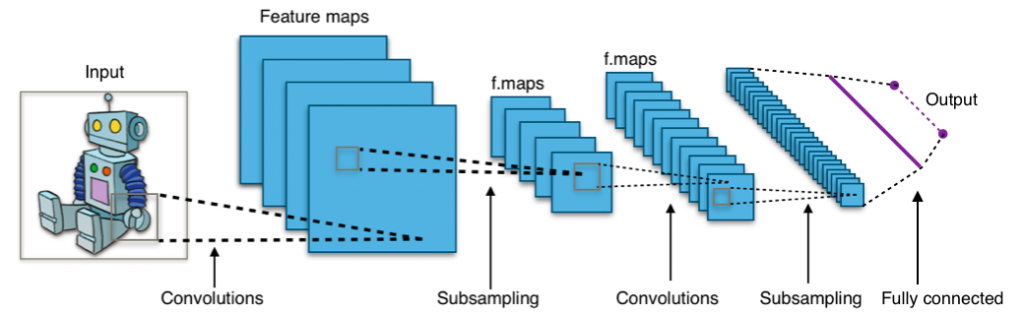

In [ ]:
# Librerias para la manipulacion numerica y aleatoria
import jax.random as random # Generar numeros aleatorios
import numpy as np

import tensorflow as tf  # Tensorflow se utiliza para cargar datasets y configurar dispositivos
import tensorflow_datasets as tfds

import jax
import optax  # Librería de optimizadores compatibles con JAX
import jax.numpy as jnp  # Versión de NumPy que funciona con JAX
import flax.linen as nn  # API para definir modelos en Flax

# TrainState es una utilidad de Flax que ayuda a mantener el estado del entrenamiento
from flax.training.train_state import TrainState
from jax import jit  # Para compilar funciones con just in time (JIT) y acelerar su ejecución

import os  # Para manipular variables del sistema
from typing import Any  # Para anotaciones de tipos generales
from datetime import datetime  # Para registrar fechas/hora

  Configuracion de GPU

In [ ]:
# Mostrar cuántas GPUs están disponibles con tensorflow
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# Lista de GPUs disónibles
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Esta línea permite que la memoria crezca según se necesite.
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Este error ocurre si ya se ha inicializado la GPU y se intenta cambiar el crecimiento de memoria
        print(e)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

os.environ.pop('TF_USE_LEGACY_KERAS', None)

Num GPUs Available:  1
1 Physical GPUs, 1 Logical GPUs
Num GPUs Available:  1


In [ ]:
# Porcentaje de datos que se usarán para entrenamient
TRAIN_PERCENT = 0.8

# El orcentaje restante que se usará para validación/pruebas
VAL_PERCENT = 1.0 - TRAIN_PERCENT

# Tasa de aprendizaje para el optimizador
LR = 1e-3

# Numero de epocas de entrenamiento
EPOCH_NUM = 10

# Tamaño al que se redimensionarán las imágenes
IMG_SIZE = (128, 128)

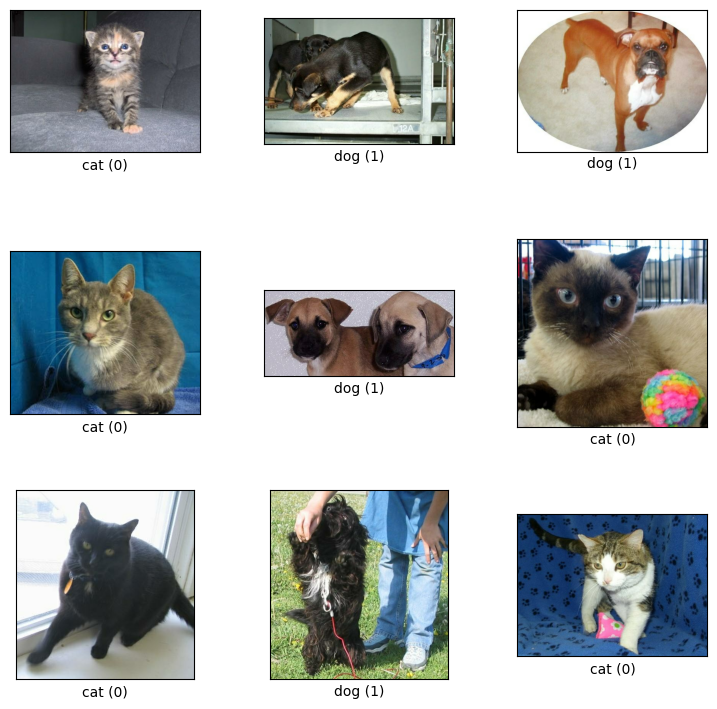

In [ ]:
# Carga el dataset 'cats_vs_dogs' desde tensorflow_datasets
# Se divide el conjunto de datos en dos partes

(train_ds, test_ds), ds_info = tfds.load(
    name = 'cats_vs_dogs',
    split=['train[:20%]', 'train[20%:30%]'],  # Division del dataset
    shuffle_files=True,  # Mezcla de los archivos para evitar sesgos
    as_supervised=True,  # Devuelve tuplas (imagen, etiqueta)
    with_info=True)  # Devuelve los metadatos

# Visualizar metadatos
fig = tfds.show_examples(train_ds, ds_info)

In [ ]:
# Mezcla aleatoria de los datos de entrenamiento
# Esto evita que el modelo vea los datos en el mismo orden en cada epoca
train_ds = train_ds.shuffle(1000)

Funcion de data augmentation

In [ ]:
# Esta función toma una imagen y su etiqueta, y le aplica transformaciones aleatorias
# Esto ayuda a que el modelo generalice mejor, es decir que tenga menos sobreajuste

def augment_data(images, labels):
   # Redimensiona la imagen al tamaño especificado (128x128 pixeles)
    images = tf.image.resize(images, IMG_SIZE)
    # Invierte aleatoriamente la imagen horizontalmente
    images = tf.image.random_flip_left_right(images)
    #images = tf.image.rot90(images)
    # Ajustes aleatorios para el brillo, el contraste y la saturacion
    images = tf.image.random_brightness(images, 0.2)
    images = tf.image.random_contrast(images, 0.5, 2.0)
    images = tf.image.random_saturation(images, 0.75, 1.25)
    # Normaliza los valores de los pixeles entre 0 y 1
    return tf.cast(images, tf.float32) / 255., labels


# Esta función aplica aumentación (opcional), mezcla, agrupa en batches y optimiza la carga

def data_load(data_ds, augmented=augment_data, shuffle_=True ,batch_=5):
  # Aplica la función de aumento a cada imagen del dataset
    data_ds = data_ds.map(
        augmented, num_parallel_calls=tf.data.AUTOTUNE)
    # Se almacena los datos en cache para que las siguientes epocas sean más rapidas
    data_ds = data_ds.cache()
    # Si se indica, se mezcla el dataset completo
    if shuffle_:
        data_ds = data_ds.shuffle(len(data_ds))
    # Agrupa los datos en lotes pequeños para el entrenamiento
    data_ds = data_ds.batch(batch_)
    # Carga datos en segundo plano mientras el modelo entrena, esto mejora el rendimiento
    data_ds = data_ds.prefetch(tf.data.AUTOTUNE)
    return data_ds


In [ ]:
# Aplica la función de carga y preprocesamiento al conjunto de entrenamiento y test
train_ds = data_load(train_ds)
test_ds = data_load(test_ds)

## Red neuronal Fully Connected

In [ ]:
# Definimos una red neuronal simple con capas densas (fully connected)
# Esta clase hereda de nn.Module de Flax

class MLP(nn.Module):
  @nn.compact
  def __call__(self, x):
    # Se aplana la imagen de [batch, 128, 128, 3] a [batch, 128*128*3]
    x = x.reshape((x.shape[0], -1))
    # Primera capa densa con 64 unidades
    x = nn.Dense(features=64)(x)
    # Funcion de activacion ReLU que introduce no linealidad
    x = nn.relu(x)
    # Capa de salida con 2 unidades para clasificacion binaria, en este caso es gato o perro
    x = nn.Dense(features=2)(x)
    return x

In [ ]:
# Instancia del modelo MLP
model = MLP()

In [ ]:
# Esta funcion inicializa los parametros del modelo y configura el optimizador

def create_train_state(rng, model, total_steps):
  # Inicializa los parametros del modelo usando una imagen de ejemplo con shape [5, 128, 128, 3]
    variables = model.init(rng, jnp.ones(
        [5, 128, 128, 3]))

    # Se crea el optimizador Adam con la tasa de aprendizaje definida anteriormente
    tx = optax.adam(learning_rate=LR)

    # Devuelve el estado de entrenamiento que contiene el modelo, los parametros y el optimizador
    return TrainState.create(apply_fn=model.apply, params=variables['params'],
    tx=tx)

In [ ]:
# Se crea una semilla aleatoria para inicializar los pesos del modelo
rng = random.PRNGKey(0)

# Calculamos el numero total de pasos de entrenamiento
# Con (tamaño del dataset * número de épocas + 1 paso extra por época)
total_steps = EPOCH_NUM*len(train_ds) + EPOCH_NUM

# Se crea el estado de entrenamiento con la funcion anterior
state = create_train_state(rng, model, total_steps)

In [ ]:
# Se separan las llaves aleatorias para diferentes partes del modelo como parametros y dropout
main_key, params_key, dropout_key = jax.random.split(key=rng, num=3)

# Desactivamos dropout por defecto en este caso no se está utilizando
dropout = False

@jit  # Compila la funcion para mayor rendimiento
def train_step(state, batch):
  # Define la funcion de pérdida
    def loss_fn(params):
        if dropout:
          # Si usamos dropout pasamos la clave para aplicarlo
          logits = state.apply_fn(
              {'params': params}, x=batch[0], rngs={'dropout': dropout_key}, train=True)
        else:
          # Caso sin dropout
          logits = state.apply_fn(
              {'params': params}, x=batch[0])
        # Codifico etiquetas en one hot para 2 clases
        one_hot = jax.nn.one_hot(batch[1], num_classes=2)
        # Calculo la perdida de entropia cruzada
        loss = optax.softmax_cross_entropy(
            logits=logits, labels=one_hot).mean()
        return loss, logits

    # Calculo de la perdida y los gradientes
    (loss, logits), grads = jax.value_and_grad(
        loss_fn, has_aux=True)(state.params)

    # Aplicacion de los gradientes al estado del modelo
    state = state.apply_gradients(grads=grads)

    # Calculo de la metrica de accuracy
    metrics = {
        'loss': loss,
        'accuracy': jnp.mean(jnp.argmax(logits, -1) == batch[1]),
    }

    return state, metrics

In [ ]:
@jit # Para eficiencia
def eval_step(state, batch):
    if dropout:
      # Si se usa dropout se desactiva en evaluacion, train=False
      logits = state.apply_fn(
          {'params': state.params}, x=batch[0], train=False, rngs={'dropout': jax.random.PRNGKey(0)}, mutable=False)
    else:
      # Llamada estandar sin dropout
      logits = state.apply_fn(
          {'params': state.params}, x=batch[0], mutable=False)

    # Calculo de la precisión (accuracy)
    metrics = {
        'accuracy': jnp.mean(jnp.argmax(logits, -1) == batch[1]),
    }
    # Se calcula la pérdida para reporte
    one_hot = jax.nn.one_hot(batch[1], num_classes=2)
    loss = optax.softmax_cross_entropy(logits=logits, labels=one_hot).mean()
    return loss, metrics

In [ ]:
# Se mide el tiempo total de entrenamiento desde este punto
start_time = datetime.now()

In [ ]:
# Convierte un tf.data.Dataset a arrays NumPy y los pasa al dispositivo
def tfds_to_numpy(ds):
    for batch in ds:
        images, labels = batch
        # Convertir cada batch a numpy arrays
        yield jax.device_put(np.array(images)), jax.device_put(np.array(labels))

In [ ]:
# Verifica la forma de un lote antes de entrenar
for dsx, lbl in train_ds.take(1):
  print(dsx.shape)

(5, 128, 128, 3)


In [ ]:
# Bucle principal de entrenamiento (EPOCH_NUM)
for epoch in range(EPOCH_NUM):
    #  Inicializa acumuladores de métricas de entrenamiento
    train_acc = 0
    train_loss = 0
    # Itera sobre los lotes del conjunto de entrenamiento
    for batch in tfds_to_numpy(train_ds):
      # Ejecuta un paso de entrenamiento (actualiza parámetros y devuelve métricas)
        state, metrics = train_step(state, batch)
        # Acumula precisión y pérdida
        train_acc += metrics['accuracy']
        train_loss += metrics['loss']

    # Promedia las métricas del entrenamiento
    train_loss /= len(train_ds)
    train_acc /= len(train_ds)
    train_acc *= 100 # Paso a porcentaje

    # Inicializa acumuladores de métricas de validacion
    val_acc = 0
    val_loss = 0
    # Itera sobre los lotes del conjunto de validacion
    for batch in tfds_to_numpy(test_ds):
        tmp_loss = 0
        # Evalúa sin actualizar parámetros
        tmp_loss, metrics = eval_step(state, batch)
        val_loss += tmp_loss
        val_acc += metrics['accuracy']

    # Promedia las métricas de validación
    val_loss /= len(test_ds)
    val_acc /= len(test_ds)
    val_acc *= 100

    # Muestra las métricas de la época actual
    print(f'EPOCH {epoch + 1}: train loss: {train_loss} train acc: {train_acc} val_loss: {val_loss} val acc: {val_acc}')

#  Calcula y muestra el tiempo total de entrenamiento
end_time = datetime.now()
print("Whole training took:", (end_time - start_time).seconds, "s")

EPOCH 1: train loss: 0.918735682964325 train acc: 49.387752532958984 val_loss: 0.6950045824050903 val acc: 50.87984848022461
EPOCH 2: train loss: 0.700655996799469 train acc: 50.15036392211914 val_loss: 0.6970571279525757 val acc: 50.8369140625
EPOCH 3: train loss: 0.7032068371772766 train acc: 50.31148147583008 val_loss: 0.6930384039878845 val acc: 50.879825592041016
EPOCH 4: train loss: 0.6932135820388794 train acc: 49.8496208190918 val_loss: 0.7045496106147766 val acc: 50.94422149658203
EPOCH 5: train loss: 0.6932324767112732 train acc: 50.49409103393555 val_loss: 0.6930131912231445 val acc: 50.87984085083008
EPOCH 6: train loss: 0.6931177973747253 train acc: 49.36626052856445 val_loss: 0.6929940581321716 val acc: 50.87984085083008
EPOCH 7: train loss: 0.6931865811347961 train acc: 49.989227294921875 val_loss: 0.6930133700370789 val acc: 50.87983703613281
EPOCH 8: train loss: 0.6931692957878113 train acc: 50.25782012939453 val_loss: 0.6931190490722656 val acc: 50.81547546386719
EPOC

In [ ]:
@jit
def pred_step(state, batch):
  # Calcula las salidas (logits) usando los parámetros actuales del modelo
  logits = state.apply_fn(
        {'params': state.params}, x=batch[0])
  # Devuelve las predicciones como la clase con mayor probabilidad
  return logits.argmax(axis=1)

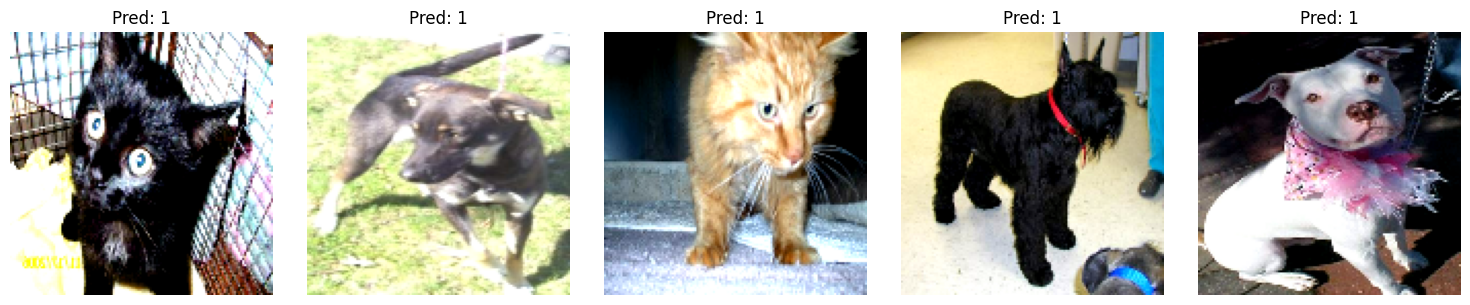

In [ ]:
# Libreria para la visualizacion
import matplotlib.pyplot as plt

# Obtiene un lote del conjunto de prueba como iterador de NumPy
test_batch = test_ds.as_numpy_iterator().next()
# Calcula las predicciones del modelo sobre este lote
pred = pred_step(state, test_batch)

# Tamaño del lote, es decir cuantas imágenes hay
batch_size = test_batch[0].shape[0]

# Crea una figura con subgráficos
fig, axs = plt.subplots(1, batch_size, figsize=(15, 3))

# Recorre cada imagen del lote
for i in range(batch_size):
    # Extrae la i-esima imagen
    img = test_batch[0][i]

    # Si las imagenes fueron normalizadas en [0, 1], puedes descomentar esto para verlas mejor
    # img = (img * 255).astype(np.uint8)

    # Muestra la imagen en escala de grises
    axs[i].imshow(img, cmap='gray')
    # Coloca el título con la predicción del modelo
    axs[i].set_title(f'Pred: {pred[i]}')
    # Quita los ejes para que se vea más limpio
    axs[i].axis('off')

# Ajusta el espaciado entre subplots
plt.tight_layout()
plt.show()

In [ ]:
# Función para evaluar el modelo en un conjunto de datos
def eval_model(state, data_loader):
    all_accs, batch_sizes = [], []
    # Recorre todos los lotes del conjunto de datos
    for batch in data_loader:
        # Evalúa el lote con la función de evaluación
        _, batch_acc = eval_step(state, batch)
        # Guarda la precisión de este lote
        all_accs.append(batch_acc['accuracy'])
        # Guarda el tamaño del lote que puede variar
        batch_sizes.append(batch[0].shape[0])
    # Calcula el promedio ponderado de precisión, esto es por si los lotes no son del mismo tamaño
    acc = sum([a*b for a,b in zip(all_accs, batch_sizes)]) / sum(batch_sizes)
    print(f"Accuracy of the model: {100.0*acc:4.2f}%")

In [ ]:
# Ejecuta la evaluación en el conjunto de prueba
eval_model(state, tfds_to_numpy(test_ds))

Accuracy of the model: 50.88%


In [ ]:
import seaborn as sns

def show_confusion_matrix(cm, labels):
  plt.figure(figsize=(10, 8))
  # Crea el mapa de calor con etiquetas
  sns.heatmap(cm, xticklabels=labels, yticklabels=labels,
              annot=True, fmt='g')
  plt.xlabel('Prediction')
  plt.ylabel('Label')
  plt.show()

In [ ]:
label_names = ds_info.features['label'].names

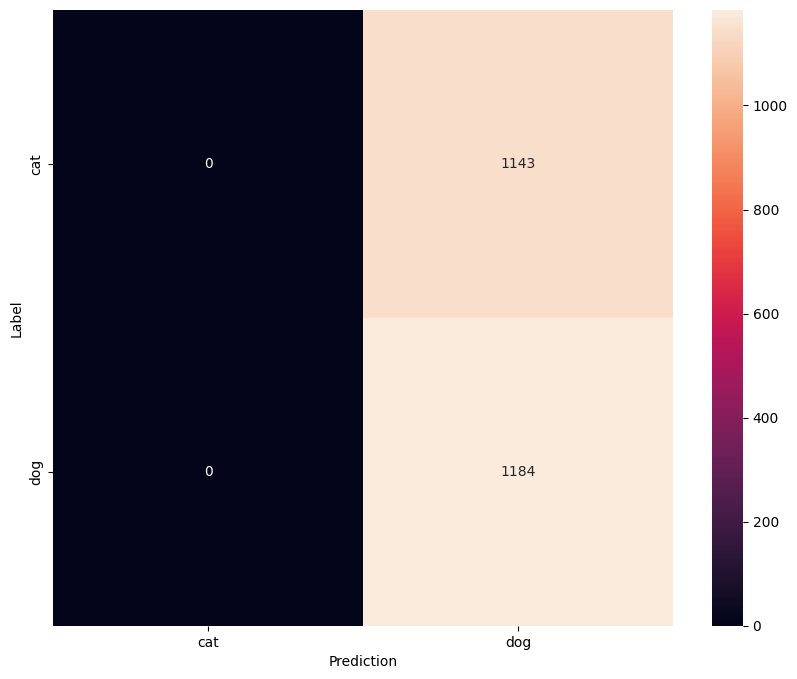

In [ ]:
pred=[]  # Lista de predicciones
lab=[]  # Lista de etiquetas verdaderas

# Recorre todos los lotes del conjunto de prueba
for ds, lb in tfds_to_numpy(test_ds):
    # Calcula los logits del modelo
    logits = state.apply_fn({'params': state.params}, x=ds)
    # Guarda la clase predicha
    pred.append(logits.argmax(axis=1))
    # Guarda la etiqueta verdadera
    lab.append(lb)

# Une todas las predicciones y etiquetas verdaderas
confusion_mtx = tf.math.confusion_matrix(
    np.concatenate(lab),
    np.concatenate(pred),
    num_classes=len(label_names))

# Matriz de confusion
show_confusion_matrix(confusion_mtx, label_names)

## Red Neuronal Convolucional

In [ ]:
class CNN(nn.Module):
  @nn.compact
  def __call__(self, x, train):
    # 1ª capa convolucional: 16 filtros de 5x5
    x = nn.Conv(features=16, kernel_size=(5, 5), strides=(1, 1), padding='SAME')(x)
    x = nn.relu(x)
    x = nn.max_pool(x, window_shape=(2, 2))

    # 2ª capa convolucional: 32 filtros de 3x3
    x = nn.Conv(features=32, kernel_size=(3, 3), strides=(1, 1))(x)
    x = nn.relu(x)
    x = nn.max_pool(x, window_shape=(2, 2))

    # 3ª capa convolucional: 32 filtros de 3x3
    x = nn.Conv(features=32, kernel_size=(3, 3), strides=(1, 1))(x)
    x = nn.relu(x)
    x = nn.max_pool(x, window_shape=(2, 2))

    # Aplana el tensor para conectarlo a la capa densa (Flatten)
    x = x.reshape((x.shape[0], -1)) # Flatten Layer

    # Capa densa con 128 unidades
    x = nn.Dense(features=128)(x)
    x = nn.relu(x)

    # Capa de dropout solo activa durante entrenamiento
    x = nn.Dropout(rate=0.2, deterministic=not train)(x)
    x = nn.Dense(features=2)(x)
    return x

In [ ]:
# Instancia del modelo CNN
modelcnn = CNN()

In [ ]:
# Función para crear el estado de entrenamiento
def create_train_state(rng, model, total_steps):
    # Inicializa los parámetros del modelo con una entrada dummy (tamaño de imagen: 128x128x3)
    variables = model.init(rng, jnp.ones(
        [5, 128, 128, 3]), train=False, capture_intermediates=True)

    # Optimizador Adam con tasa de aprendizaje definida (LR)
    tx = optax.adam(learning_rate=LR)

    # Crea el estado de entrenamiento con los parámetros y el optimizador
    return TrainState.create(apply_fn=model.apply, params=variables['params'],
    tx=tx)

In [ ]:
# Crea el estado de entrenamiento para la red
cnn_state = create_train_state(rng, modelcnn, total_steps)

In [ ]:
dropout = True # Activa el dropout durante el entrenamiento
for epoch in range(EPOCH_NUM): # Repite por el número total de épocas
    train_acc = 0
    train_loss = 0

    # Entrenamiento por batches
    for batch in tfds_to_numpy(train_ds):
        # Ejecuta un paso de entrenamiento: obtiene el nuevo estado y métricas
        state, metrics = train_step(cnn_state, batch)
        # Acumula precisión y pérdida del batch
        train_acc += metrics['accuracy']
        train_loss += metrics['loss']

    # Promedia sobre todos los batches
    train_loss /= len(train_ds)
    train_acc /= len(train_ds)
    train_acc *= 100

    val_acc = 0
    val_loss = 0

    # Validación del modelo sin actualizar pesos
    for batch in tfds_to_numpy(test_ds):
        tmp_loss = 0
        # Evalúa sin modificar el estado
        tmp_loss, metrics = eval_step(cnn_state, batch)
        val_loss += tmp_loss
        val_acc += metrics['accuracy']

    # Promedia sobre todos los batches de validación
    val_loss /= len(test_ds)
    val_acc /= len(test_ds)
    val_acc *= 100

    # Metricas de la epoca
    print(f'EPOCH {epoch + 1}: train loss: {train_loss} train acc: {train_acc} val_loss: {val_loss} val acc: {val_acc}')

# Medición del tiempo de entrenamiento total
end_time = datetime.now()
print("Whole training took:", (end_time - start_time).seconds, "s")

EPOCH 1: train loss: 0.6987531185150146 train acc: 50.848506927490234 val_loss: 0.6976022124290466 val acc: 52.532203674316406
EPOCH 2: train loss: 0.6984348893165588 train acc: 51.40709686279297 val_loss: 0.6974813938140869 val acc: 52.66098403930664
EPOCH 3: train loss: 0.6987412571907043 train acc: 50.32223892211914 val_loss: 0.6975493431091309 val acc: 52.59661102294922
EPOCH 4: train loss: 0.6996476054191589 train acc: 50.34369659423828 val_loss: 0.6973447203636169 val acc: 52.66096115112305
EPOCH 5: train loss: 0.6982977986335754 train acc: 50.67671585083008 val_loss: 0.697439432144165 val acc: 52.5965690612793
EPOCH 6: train loss: 0.6995208263397217 train acc: 50.46187210083008 val_loss: 0.6975973844528198 val acc: 52.5965690612793
EPOCH 7: train loss: 0.7006592750549316 train acc: 50.07521438598633 val_loss: 0.6974680423736572 val acc: 52.59660339355469
EPOCH 8: train loss: 0.6997382640838623 train acc: 50.54777908325195 val_loss: 0.6975866556167603 val acc: 52.59659957885742
E

In [ ]:
# # Evaluar el modelo con el conjunto de prueba
eval_model(cnn_state, tfds_to_numpy(test_ds))

Accuracy of the model: 52.60%


In [ ]:
# Crear una entrada de prueba (imagen vacía de tamaño 128x128x3)
x = jnp.ones([1, 128, 128, 3])
# Inicializar las variables del modelo con un batch simulado
variables = modelcnn.init(rng, jnp.ones([5, 128, 128, 3]), train=False, capture_intermediates=True)

# Aplicar el modelo a la imagen simulada para capturar activaciones
outputs, state = modelcnn.apply(
    variables,
    x,
    train=False,
    capture_intermediates=True,
    mutable=['intermediates']
)


# Extraer las activaciones intermedias del estado
intermediates = state['intermediates']

# Mostrar el nombre de cada capa y su activación correspondiente
for name, acts in intermediates.items():
    print(f"{name}: {acts}")

Conv_0: {'__call__': (Array([[[[ 0.59381086,  0.24038175,  0.55991614, ...,  0.27607986,
           0.47167867, -0.2729288 ],
         [ 0.02421333, -0.40615797,  0.2459003 , ...,  0.3059722 ,
           0.6760822 ,  0.32261518],
         [ 0.43459523, -0.3061297 , -0.02065134, ...,  0.80344087,
           0.72641534, -0.01792037],
         ...,
         [ 0.43459523, -0.3061297 , -0.02065134, ...,  0.80344087,
           0.72641534, -0.01792037],
         [ 0.5146028 , -0.64237577, -1.0102191 , ...,  0.709882  ,
           0.73550963,  0.38419202],
         [ 0.13290115, -0.6564239 , -0.57066566, ...,  0.8390464 ,
           0.46127367,  0.25604343]],

        [[ 0.01906963,  0.5904031 ,  0.35142383, ...,  0.5511039 ,
           0.72274643,  0.35528746],
         [-0.54255015,  0.04693471, -0.06239533, ...,  0.52947116,
           0.9862258 ,  1.0424224 ],
         [ 0.08061513,  0.36869052, -0.38610125, ...,  1.2498076 ,
           1.0214031 ,  0.50549066],
         ...,
         [ 0

## Convoluciones de 1 dimensión

In [ ]:
import pandas as pd
df = pd.read_csv('Sunspots_.csv', index_col=0)
df.head()

,Date,Monthly Mean Total Sunspot Number
0,1749-01-31,96.7
1,1749-02-28,104.3
2,1749-03-31,116.7
3,1749-04-30,92.8
4,1749-05-31,141.7


<Axes: >

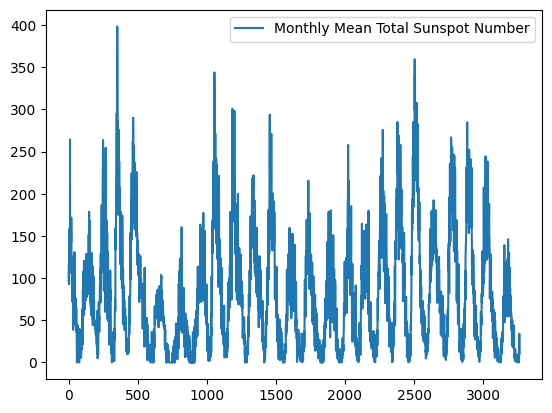

In [ ]:
df.plot()

In [ ]:
# Extraemos los datos de tiempo como un array de NumP
time_index = np.array(df['Date'])

# Extraemos los valores de la serie temporal (número de manchas solares mensuales)
data = np.array(df['Monthly Mean Total Sunspot Number'])

# Imprimimos las formas de los arrays para confirmar que coinciden
print(time_index.shape)
print(data.shape)

(3265,)
(3265,)


In [ ]:
# Hiperparametros
SPLIT_TEST_TRAIN = 0.8  # 80% de los datos para entrenamiento, 20% para prueba
WINDOW_SIZE = 60  # Tamaño de la ventana deslizante para entradas secuenciales
BATCH_SIZE = 32  # Tamaño del batch para entrenamient
SHUFFLE_BUFFER = 1000  # Buffer para mezcla aleatoria de datos en el entrenamiento

In [ ]:
# Calculamos el índice donde se separan los datos de entrenamiento y prueba
split_index = int(SPLIT_TEST_TRAIN * data.shape[0])
print(split_index)

2612


In [ ]:
# División de los datos de entrenamiento
train_data = data[:split_index]
train_time = time_index[:split_index]

# División de los datos de prueba
test_data = data[split_index:]
test_time = time_index[split_index:]

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import jax.numpy as jnp

# Función para graficar las predicciones del modelo sobre el set de prueba
def plots_pred_flax(state, data, test_data, split_index, window_size=60):
    preds = []  # Lista donde se guardarán las predicciones

    # Recorremos desde el final del entrenamiento hasta el final de los datos
    for t in range(split_index - window_size, len(data) - window_size):
        # ventana de tamaño window_size
        x_win = data[t : t + window_size]
        # batch dim y canal dim: (1, window_size, 1)
        x_input = jnp.array(x_win)[None, :, None]
        # inferencia
        y_hat_seq = state.apply_fn({'params': state.params}, x_input)
        # extraer la última predicción
        preds.append(np.array(y_hat_seq)[0, -1, 0])

    # Convertimos las predicciones a un array de NumPy
    preds = np.array(preds)

    # Calculamos el error absoluto medio (MAE)
    mae = np.mean(np.abs(preds - test_data))

    plt.figure(figsize=(14,6))
    # Creamos un vector de tiempo para las predicciones
    times = np.arange(split_index, split_index + len(preds))
    plt.plot(times, test_data,    label='Datos reales',     linewidth=2)
    plt.plot(times, preds,        label='Predicciones',      linewidth=2)
    # Rellenamos el área ± MAE para ver la variabilidad del error
    plt.fill_between(times,
                     preds - mae,
                     preds + mae,
                     color='gray',
                     alpha=0.3,
                     label='± MAE')

    plt.title("Predicción paso a paso con CNN 1D (Flax/JAX)")
    plt.xlabel("Índice de tiempo")
    plt.ylabel("Valor de la serie")
    plt.legend()
    plt.show()

    # Imprimimos el MAE sobre el conjunto de prueba
    print(f"MAE sobre test: {mae:.4f}")


In [ ]:
import jax
import jax.numpy as jnp
import optax
from flax.training import train_state
from flax import linen as nn

class CNN1D_TimeSeries(nn.Module):
    @nn.compact
    def __call__(self, x):
      # Primera capa convolucional con padding causal (para series temporales)
        x = nn.Conv(features=32, kernel_size=(3,), padding='CAUSAL')(x)
        x = nn.relu(x)  # Función de activación ReLU
        # Segunda capa convolucional con kernel 1 (proporciona una predicción por paso)
        x = nn.Conv(features=1, kernel_size=(1,), padding='VALID')(x)
        return x

def create_train_state(rng, learning_rate):
    """Inicializa TrainState con parámetros y optimizador Adam."""
    model = CNN1D_TimeSeries()

    # Creamos un input dummy para inicializar los pesos del modelo
    dummy_input = jnp.zeros((1, WINDOW_SIZE, 1))
    params = model.init(rng, dummy_input)['params']  # Inicializa pesos

    # Usamos el optimizador Adam con tasa de aprendizaje dada
    tx = optax.adam(learning_rate)

    # Creamos el objeto TrainState para manejar entrenamiento
    return train_state.TrainState.create(
        apply_fn=model.apply,
        params=params,
        tx=tx
    )

In [ ]:
import jax.numpy as jnp

def mse_loss(params, batch):

    x_batch, y_batch = batch  # Separar inputs y targets

    # Hacer predicciones usando el modelo
    preds = CNN1D_TimeSeries().apply({'params': params}, x_batch) # → (B, 60, 1)
    # Tomar solo la última predicción de la secuencia
    preds_last = preds[:, -1, 0]                                  # → (B,)
    # Calcular el MSE entre la predicción y la etiqueta real
    loss = jnp.mean((preds_last - y_batch) ** 2)
    return loss, preds_last


In [ ]:
import jax

@jax.jit
def train_step(state, batch):
  # Calcula la pérdida y su gradiente respecto a los parámetros
    (loss, _), grads = jax.value_and_grad(mse_loss, has_aux=True)(
        state.params, batch
    )
    # Aplica los gradientes para actualizar los parámetros del modelo
    new_state = state.apply_gradients(grads=grads)
    return new_state, loss

@jax.jit
def eval_step(state, batch):
  # Unicamente calcula la pérdida MSE para el batch
    loss, _ = mse_loss(state.params, batch)
    return loss


In [ ]:
def ts_data_timeseries(data, window_size, batch_size):
    ds = tf.data.Dataset.from_tensor_slices(data)  # Crea dataset de los datos crudos

    # Genera ventanas deslizantes de longitud window_size + 1
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)

    # Convierte cada ventana a tensor y agrupa en batches
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))

    # Divide cada ventana en input y target (último valor)
    ds = ds.map(lambda w: (w[:-1][..., tf.newaxis], w[-1]))

    # Mezcla, agrupa en lotes y prefetch para eficiencia
    ds = ds.shuffle(SHUFFLE_BUFFER).batch(batch_size).prefetch(1)
    return ds

#  Preparación de datasets y entrenamiento
train_ds = ts_data_timeseries(train_data, WINDOW_SIZE, BATCH_SIZE)
test_ds  = ts_data_timeseries(test_data,  WINDOW_SIZE, BATCH_SIZE)


rng = jax.random.PRNGKey(0)  # Llave aleatoria para inicialización
state = create_train_state(rng, learning_rate=1e-3)  # Inicializa modelo y optimizador


for epoch in range(1, 20 + 1):

    for x_tf, y_tf in train_ds.as_numpy_iterator():
        batch = (jnp.array(x_tf), jnp.array(y_tf))
        state, loss = train_step(state, batch)  # Entrena modelo
    val_losses = []
    for x_tf, y_tf in test_ds.as_numpy_iterator():  # Evaluación en conjunto de prueba
        batch = (jnp.array(x_tf), jnp.array(y_tf))
        val_losses.append(eval_step(state, batch))  # Calcula pérdida
    print(f"Epoch {epoch}, Val MSE: {jnp.mean(jnp.array(val_losses)):.4f}")


Epoch 1, Val MSE: 624.7987
Epoch 2, Val MSE: 570.8381
Epoch 3, Val MSE: 554.4445
Epoch 4, Val MSE: 542.7923
Epoch 5, Val MSE: 543.2783
Epoch 6, Val MSE: 549.6284
Epoch 7, Val MSE: 542.0204
Epoch 8, Val MSE: 540.0952
Epoch 9, Val MSE: 536.2202
Epoch 10, Val MSE: 549.0096
Epoch 11, Val MSE: 535.8967
Epoch 12, Val MSE: 540.7622
Epoch 13, Val MSE: 546.3714
Epoch 14, Val MSE: 547.9097
Epoch 15, Val MSE: 542.4932
Epoch 16, Val MSE: 550.2352
Epoch 17, Val MSE: 544.3683
Epoch 18, Val MSE: 535.6670
Epoch 19, Val MSE: 544.3581
Epoch 20, Val MSE: 540.5860


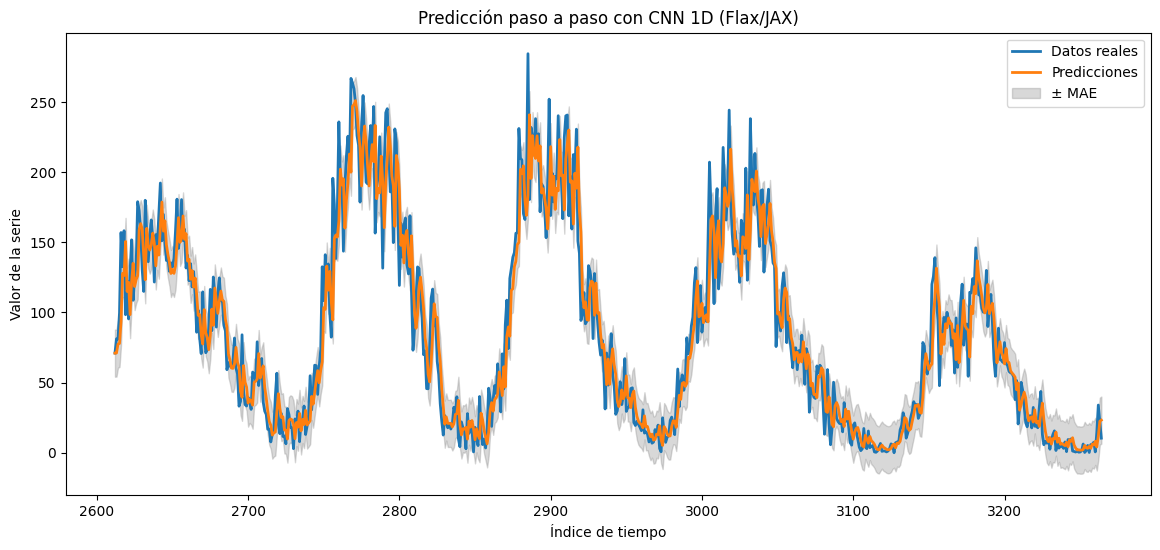

MAE sobre test: 16.8125


In [ ]:
plots_pred_flax(state, data, data[split_index:], split_index, WINDOW_SIZE)

### Transfer Learning con JAX

In [ ]:
!pip install --upgrade git+https://github.com/matthias-wright/flaxmodels.git

  Cloning https://github.com/matthias-wright/flaxmodels.git to /tmp/pip-req-build-rdm9gbot
  Running command git clone --filter=blob:none --quiet https://github.com/matthias-wright/flaxmodels.git /tmp/pip-req-build-rdm9gbot
  Resolved https://github.com/matthias-wright/flaxmodels.git to commit 09bc77215032375d124e3f1eba828dd89c80a850
  Preparing metadata (setup.py) ... done
  Created wheel for flaxmodels: filename=flaxmodels-0.1.3-py3-none-any.whl size=115994 sha256=b61d7f3307d1460c978d927205c4cff445e281a8f24bc818c9d4d9aa0fcab793
  Stored in directory: /tmp/pip-ephem-wheel-cache-lqtegbth/wheels/f6/e2/ba/f9200dc068890a7ff5e5fa1e3e3c9da9410048a91e639384c3
Successfully built flaxmodels


In [ ]:
from flaxmodels import ResNet50
import jax.numpy as jnp
import jax

backbone = ResNet50(pretrained=True)

x = jnp.ones((1, 224, 224, 3))
rng = jax.random.PRNGKey(0)
variables = backbone.init(rng, x)

features = backbone.apply(variables, jnp.ones((1,224,224,3)))

import flax.linen as nn
class Head(nn.Module):
    num_classes: int
    @nn.compact
    def __call__(self, x):
        x = jnp.mean(x, axis=(1,2))
        return nn.Dense(self.num_classes)(x)

head = Head(num_classes=10)




ModifyScopeVariableError: Cannot update variable "mean" in "/BatchNorm_0" because collection "batch_stats" is immutable. (https://flax.readthedocs.io/en/latest/api_reference/flax.errors.html#flax.errors.ModifyScopeVariableError)